<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/Helmholtz_equation_Pinns_for_Qiita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ③-0.準備

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print(device)

cuda


# ③-Ⅰ.Loss関数の設定
### Helmholtz方程式
### Loss関数の定義
$$ \frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2} +(4\pi)^2u = (4π)^2sin(4πx)sin(4πy) $$
### 式を変形して
$$ Loss_{PINN}=\frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2} +(4\pi)^2u - (4π)^2sin(4πx)sin(4πy) $$

In [5]:
criteria = nn.MSELoss()
# np.piをtorch.tensorに変換する(GPU使用)
pi_tensor = torch.tensor(np.pi,device=device)

In [6]:
def physics_informed_loss(x, y, net):
  u = net(x, y)

  u_x = torch.autograd.grad(
    u, x,
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]
  u_xx = torch.autograd.grad(
    u_x, x,
    grad_outputs=torch.ones_like(u_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]

  u_y = torch.autograd.grad(
    u, y,
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]

  u_yy = torch.autograd.grad(
    u_y, y,
    grad_outputs=torch.ones_like(u_y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]

  # Loss_PINNの定義
  pinn_loss = (u_xx)+(u_yy )+( (4*pi_tensor)*(4*pi_tensor)*u ) - (4*pi_tensor)*(4*pi_tensor)*torch.sin(4*pi_tensor*x)*torch.sin(4*pi_tensor*y)
  # Loss_PINNをゼロにするように設定(MSE)
  zeros_t = torch.zeros(pinn_loss.size()).to(device)
  pinn_loss_ = criteria(pinn_loss, zeros_t)
  return pinn_loss_

### 境界条件に関する定義
$$ u(x=0,y)=u(x,y=0)=0, u(x=1,y)=u(x,y=1)=0 $$

In [7]:
x_bc = np.array([0.0, 1.0])
y_bc = np.array([0.0, 1.0])
bc_sample_size = 500
t_bc = np.linspace(0, 1.0, bc_sample_size)

# x = 0.0
X_bc1 = np.zeros([bc_sample_size, 3])
X_bc1[:,0] = 0.0
X_bc1[:,1] = t_bc
X_bc1[:,2] = y_bc[0]

# x = 1.0
X_bc2 = np.zeros([bc_sample_size, 3])
X_bc2[:,0] = 1.0
X_bc2[:,1] = t_bc
X_bc2[:,2] = y_bc[1]

# y = 0.0
Y_bc1 = np.zeros([bc_sample_size, 3])
Y_bc1[:,0] = t_bc
Y_bc1[:,1] = 0.0
Y_bc1[:,2] = x_bc[0]

# y = 1.0
Y_bc2 = np.zeros([bc_sample_size, 3])
Y_bc2[:,0] = t_bc
Y_bc2[:,1] = 1.0
Y_bc2[:,2] = x_bc[1]

# stack
X_bc_stack = np.vstack([X_bc1, X_bc2, Y_bc1, Y_bc2])
u_bc_stack = np.zeros(X_bc_stack.shape[0])

X_bc_t = torch.tensor(X_bc_stack, requires_grad=True).float().to(device)
u_bc_t = torch.tensor(u_bc_stack, requires_grad=True).float().to(device).unsqueeze(dim=1)


In [8]:
def boundary_condition_loss(x, y, net, u_bc):
  u = net(x, y)
  bc_condition_loss = criteria(u, u_bc)
  return bc_condition_loss

# ③-Ⅱ.空間のサンプリング

In [9]:
# sampling point
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X, Y = np.meshgrid(x_, y_, indexing='ij')
x_flat = X.flatten()
y_flat = Y.flatten()

# sampling size
sampling_size = 5000
random_idx = np.random.choice(np.arange(x_flat.shape[0]),size=sampling_size,replace=False)

#
# sampling
#
x_sampled = x_flat[random_idx]
y_sampled = y_flat[random_idx]
X_sampled = np.zeros([sampling_size,2])
X_sampled[:,0] = x_sampled
X_sampled[:,1] = y_sampled
X_sample_t = torch.tensor(X_sampled,requires_grad=True).float().to(device)

# ③-Ⅲ.DNNの設定
入力因子はx,yの2因子
最終層はlinearでつないでuを出力する

In [10]:
class PINN(torch.nn.Module):
  def __init__(self,activation='relu'):
    super().__init__()
    self.regressor = nn.Linear(5, 1)
    self.activation = activation
    self.linear1 = self.linear(2,5,activation = self.activation)
    self.linear2 = self.linear(5,20,activation = self.activation)
    self.linear3 = self.linear(20,80,activation = self.activation)
    self.linear4 = self.linear(80,160,activation = self.activation)
    self.linear5 = self.linear(160,160,activation = self.activation)
    self.linear6 = self.linear(160,80,activation = self.activation)
    self.linear7 = self.linear(80,40,activation = self.activation)
    self.linear8 = self.linear(40,5,activation = self.activation)

  def linear(self, in_features, out_features, activation='relu'):
    layers = [nn.Linear(in_features, out_features)]
    if activation == 'relu':
      layers.append(nn.ReLU(inplace=True))
    elif activation == 'tanh':
      layers.append(nn.Tanh())
    else:
      layers.append(nn.Sigmoid())
    net = nn.Sequential(*layers)
    return net
  def forward(self,x,t):
    inputs = torch.cat([x,t],axis=1)
    out = self.linear1(inputs)
    out = self.linear2(out)
    out = self.linear3(out)
    out = self.linear4(out)
    out = self.linear5(out)
    out = self.linear6(out)
    out = self.linear7(out)
    out = self.linear8(out)
    out = self.regressor(out)
    return out

# ③-Ⅳ.学習
活性化関数はReLU,学習率は0.001,エポック数は10000

In [11]:
net = PINN(activation='relu').to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epoch = 10000

In [12]:
losses=[]
pinn_losses=[]
bnd_losses=[]

for epoch in range(num_epoch):
  optimizer.zero_grad()

  # PINN loss
  x_sampled = X_sample_t[:,0].unsqueeze(dim=-1).to(device)
  y_sampled = X_sample_t[:,1].unsqueeze(dim=-1).to(device)
  pinn_loss = physics_informed_loss(x_sampled, y_sampled, net)

  # bc loss
  x_bnd = X_bc_t[:,0].unsqueeze(dim=-1).to(device)
  y_bnd = X_bc_t[:,1].unsqueeze(dim=-1).to(device)
  bnd_loss = boundary_condition_loss(x_bnd,y_bnd,net,u_bc_t)
  # Loss_total
  loss = pinn_loss  + bnd_loss
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  pinn_losses.append(pinn_loss.item())
  bnd_losses.append(bnd_loss.item())

  if epoch % 500 == 0:
    loss_ = loss.item()
    pinn_loss_ = pinn_loss.item()
    #ini_loss_ = ini_loss.item()
    bnd_loss_ = bnd_loss.item()
    print(f'epoch:{epoch:.3e},loss:{loss_:.3e},pinn:{pinn_loss_:.3e},bnd:{bnd_loss:.3e}')

epoch:0.000e+00,loss:6.548e+03,pinn:6.548e+03,bnd:1.936e-02
epoch:5.000e+02,loss:2.617e+03,pinn:2.617e+03,bnd:1.160e-01
epoch:1.000e+03,loss:2.318e+03,pinn:2.318e+03,bnd:1.152e-01
epoch:1.500e+03,loss:1.322e+03,pinn:1.322e+03,bnd:8.797e-02
epoch:2.000e+03,loss:4.052e+02,pinn:4.052e+02,bnd:3.322e-02
epoch:2.500e+03,loss:1.710e+02,pinn:1.709e+02,bnd:1.792e-02
epoch:3.000e+03,loss:2.779e+02,pinn:2.778e+02,bnd:1.869e-02
epoch:3.500e+03,loss:9.127e+01,pinn:9.126e+01,bnd:9.636e-03
epoch:4.000e+03,loss:8.714e+01,pinn:8.713e+01,bnd:7.981e-03
epoch:4.500e+03,loss:6.746e+01,pinn:6.745e+01,bnd:7.468e-03
epoch:5.000e+03,loss:6.390e+01,pinn:6.389e+01,bnd:6.596e-03
epoch:5.500e+03,loss:7.283e+01,pinn:7.283e+01,bnd:6.267e-03
epoch:6.000e+03,loss:4.882e+01,pinn:4.882e+01,bnd:5.153e-03
epoch:6.500e+03,loss:3.406e+01,pinn:3.405e+01,bnd:4.117e-03
epoch:7.000e+03,loss:5.295e+01,pinn:5.294e+01,bnd:4.858e-03
epoch:7.500e+03,loss:3.758e+01,pinn:3.757e+01,bnd:3.598e-03
epoch:8.000e+03,loss:3.665e+01,pinn:3.66

Loss関数の推移を確認する

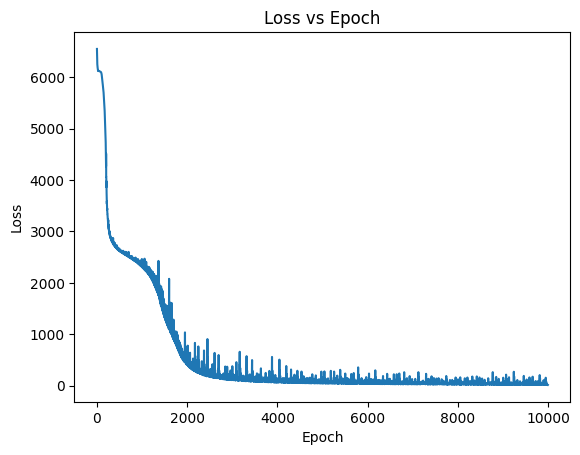

In [13]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
#plt.yscale('log')
plt.show()

Loss_PINNの推移を確認する

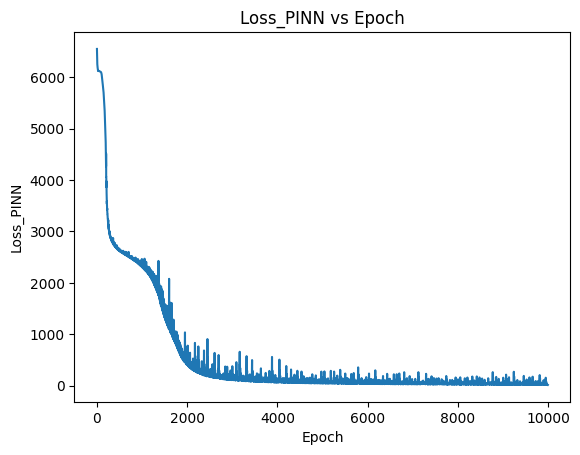

In [14]:
plt.plot(pinn_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss_PINN')
plt.title('Loss_PINN vs Epoch')
#plt.yscale('log')
plt.show()

Loss_boundaryの推移を確認する

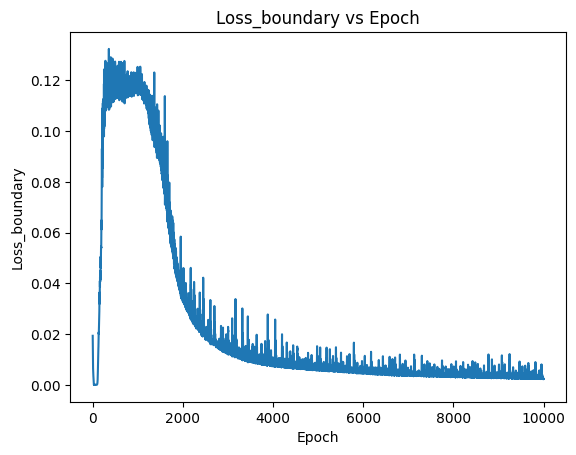

In [15]:
plt.plot(bnd_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss_boundary')
plt.title('Loss_boundary vs Epoch')
#plt.yscale('log')
plt.show()

# ③-V.検証

PINNで推論する

In [16]:
X_test = np.zeros([x_flat.shape[0],2])
X_test[:,0] = x_flat
X_test[:,1] = y_flat

X_test_t = torch.tensor(X_test).float().to(device)
x_test = X_test_t[:,0].unsqueeze(dim=-1)
y_test = X_test_t[:,1].unsqueeze(dim=-1)
u_pred = net(x_test , y_test)

xtest=x_test.cpu().numpy()
ytest=y_test.cpu().numpy()
upred=u_pred.cpu().detach().numpy()


厳密解を計算する

In [17]:
import numpy as np

# x, y の範囲と刻み幅の設定
x_range = np.arange(0, 1.001, 0.001)
y_range = np.arange(0, 1.001, 0.001)

# exact_dataを格納する辞書の初期化
exact_data = {'x': [], 'y': [], 'z': []}

# x, y のループを回して exact を計算し exact_data に格納
for x in x_range:
    for y in y_range:
        #exact = (4*np.pi)*(4*np.pi)*np.sin(4*np.pi*x)*np.sin(4*np.pi*y)
        exact = np.sin(4*np.pi*x)*np.sin(4*np.pi*y)
        exact_data['x'].append(x)
        exact_data['y'].append(y)
        exact_data['z'].append(exact)

# exact_dataをnumpy配列に変換
exact_data['x'] = np.array(exact_data['x'])
exact_data['y'] = np.array(exact_data['y'])
exact_data['z'] = np.array(exact_data['z'])

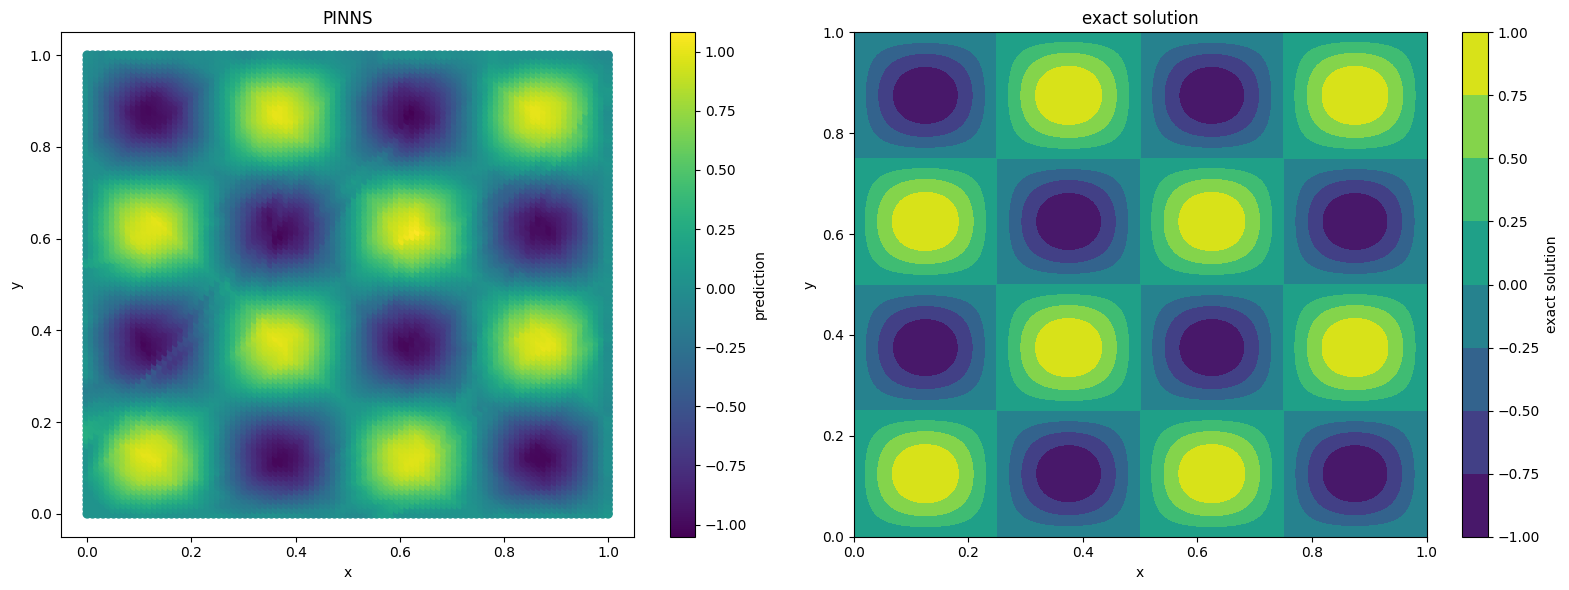

In [18]:

# exact_dataからx, y, zを取得
x = exact_data['x']
y = exact_data['y']
z = exact_data['z']

# PINNの結果のプロット
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(xtest, ytest, c=upred, cmap='viridis')
plt.colorbar(label='prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINNS')

# 厳密解のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.contourf(x.reshape(1001, 1001), y.reshape(1001, 1001), z.reshape(1001, 1001), cmap='viridis')
plt.colorbar(label='exact solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('exact solution')

plt.tight_layout()  # レイアウトの調整
plt.show()
